In [1]:
import time

from pyAgrum.lib.bn2graph import BN2dot
import numpy as np
import pandas as pd

import pyAgrum as gum
import pyAgrum.lib.notebook as gnb
import pyAgrum.lib.explain as ex

import matplotlib.pyplot as plt

# Building the model

In [2]:
template=gum.fastBN("X1->X2->Y;X3->Z->Y;X0->Z;X1->Z;X2->R[5];Z->R;X1->Y")
data_path = "res/shap/Data_6var_direct_indirect.csv" 

#gum.generateCSV(template,data_path,1000)

learner = gum.BNLearner(data_path,template)
bn = learner.learnParameters(template.dag())


In [3]:
bn

(gum::BayesNet<double>@000002367F2F4C50) BN{nodes: 7, arcs: 9, domainSize: 320, dim: 62}

In [4]:
target = 'Y'

In [5]:
df = pd.read_csv(data_path).sample(frac=1.)
train = df.copy()

Get list of features for prediction, it contains all the variblaes except the target.

# ShapValues()

In [6]:
gumshap = ex.ShapValues(bn, 'Y')

## Compute Conditionnal in Bayesian Network

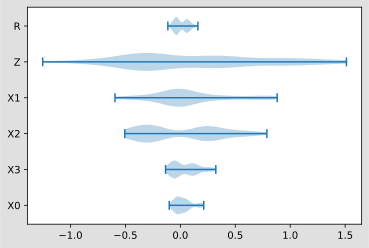

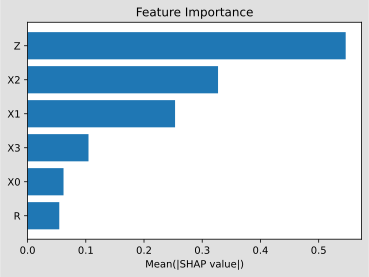

Run Time : 8.262011289596558 sec


In [7]:
t_start = time.time()
resultat = gumshap.conditional(train, plot=True,plot_importance=True,percentage=False)
print(f'Run Time : {time.time()-t_start} sec')

In [8]:
resultat

{'X0': 0.06176712200000176,
 'X3': 0.10465402104047894,
 'X2': 0.32716064437520065,
 'X1': 0.2533375405370652,
 'Z': 0.5464180054433384,
 'R': 0.054456334441524}

## Prediction on Markov Blanket

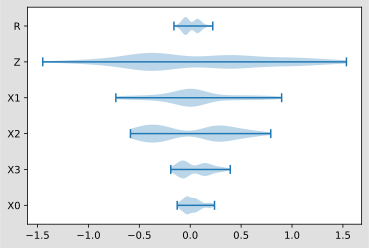

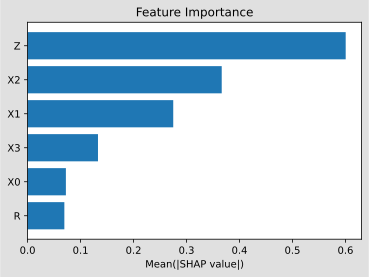

Run Time : 94.26600742340088 sec


In [9]:
t_start = time.time()
markov = gumshap.conditionalMarkovBlanket(train, plot=True,plot_importance=True,percentage=False)
print(f'Run Time : {time.time()-t_start} sec')

# Marginal Shap Values

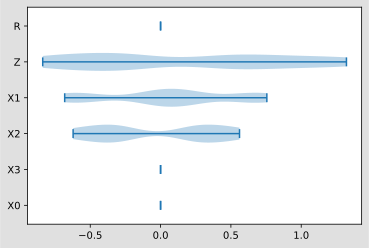

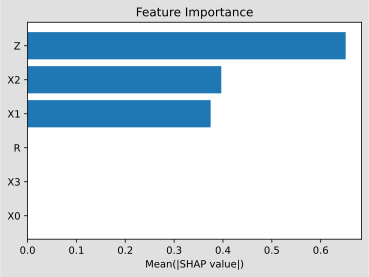

Run Time : 535.0357830524445 sec


In [10]:
t_start = time.time()
marginal = gumshap.marginal(train, sample_size=200, plot=True,plot_importance=True,percentage=False)
print(f'Run Time : {time.time()-t_start} sec')

In [11]:
marginal

{'X0': 0.0,
 'X3': 0.0,
 'X2': 0.39656296732028473,
 'X1': 0.37478075327077043,
 'Z': 0.6512003319384269,
 'R': 0.0}

# Causal Shap Values

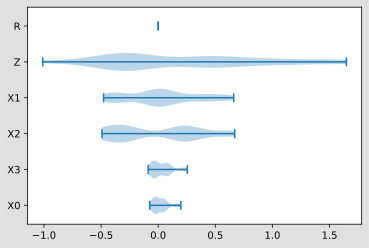

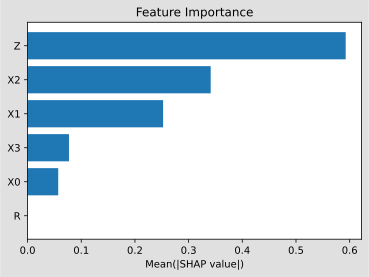

Run Time : 8.941993951797485 sec


In [12]:
t_start = time.time()
causal = gumshap.causal(train, plot=True,plot_importance=True,percentage=False)
print(f'Run Time : {time.time()-t_start} sec')

## Colored BN

In [13]:
from IPython.display import Image, display

In [14]:
g = gumshap.showShapValues(causal)

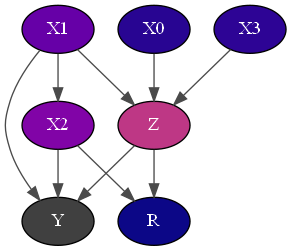

In [15]:
display(Image(g.create_png()))

In [16]:
import math
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt